In [1]:
import os
import json
import math
import itertools
import networkx as nx
import graph_tool as gt
import matplotlib
%matplotlib inline

import community
import matplotlib.pyplot as plt
import graph_tool.draw

from collections import defaultdict, Counter
from bidict import bidict

In [19]:
MIN_EDGE = 20

OUTPUT_DIR = "/Users/altaf/Projects/dnm_evolution/data/agora/topics"

files = os.listdir(OUTPUT_DIR)[1:40000]

users = bidict()

def get_user_id(user):
    user_id = users.get(user, -1)
    if (user_id < 0):
        user_id = len(users)
        users[user] = user_id
    return(user_id)

edge_list = Counter()

for filename in files:
    topic = json.load(open(os.path.join(OUTPUT_DIR, filename)))
    if len(topic["posters"]) <= 1:
        continue
    
    posters = sorted(topic["posters"])
    for edge in itertools.combinations(posters, 2):
        edge_list[edge] += 1

def get_edge(e):
    return(tuple(sorted([get_user_id(u) for u in e])))
    
edges = {get_edge(e): edge_list[e] for e in edge_list.keys() if edge_list[e] > MIN_EDGE}

len(edges)

494

In [20]:
g = gt.Graph(directed=False)
g.add_edge_list(edges)

g.vertex_properties['label'] = g.new_vertex_property('string')
for v in g.vertices():
    g.vertex_properties['label'][v] = users.inv[g.vertex_index[v]]
print('g vert/edges: ',g.num_vertices(), g.num_edges())

#add edge weight property
g.edge_properties['weight'] = g.new_edge_property('double')
g.edge_properties['color'] = g.new_edge_property('vector<double>')
for e in g.edges():
    w = edges[tuple(sorted([e.source(),e.target()]))]
    g.edge_properties['weight'][e] = w
    alpha = (float(w)/max(edge_list.values())) + .025
    g.edge_properties['color'][e] = [103/255.0,134/255.0,239/255.0,alpha]  
    

('g vert/edges: ', 166, 494)


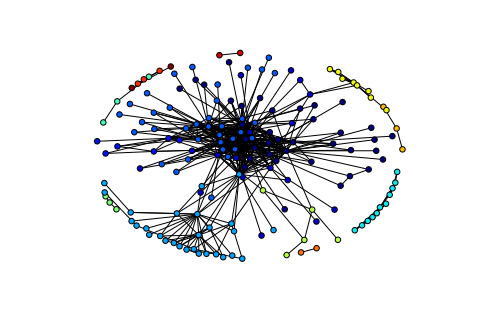

In [22]:
gx = nx.Graph()
gx.add_nodes_from(users.values())
gx.add_edges_from(edges.keys())
part = community.best_partition(gx)
mod = community.modularity(part, gx)

values = [part.get(node) for node in gx.nodes()]
nx.draw_spring(gx, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.show()


saving to disk...


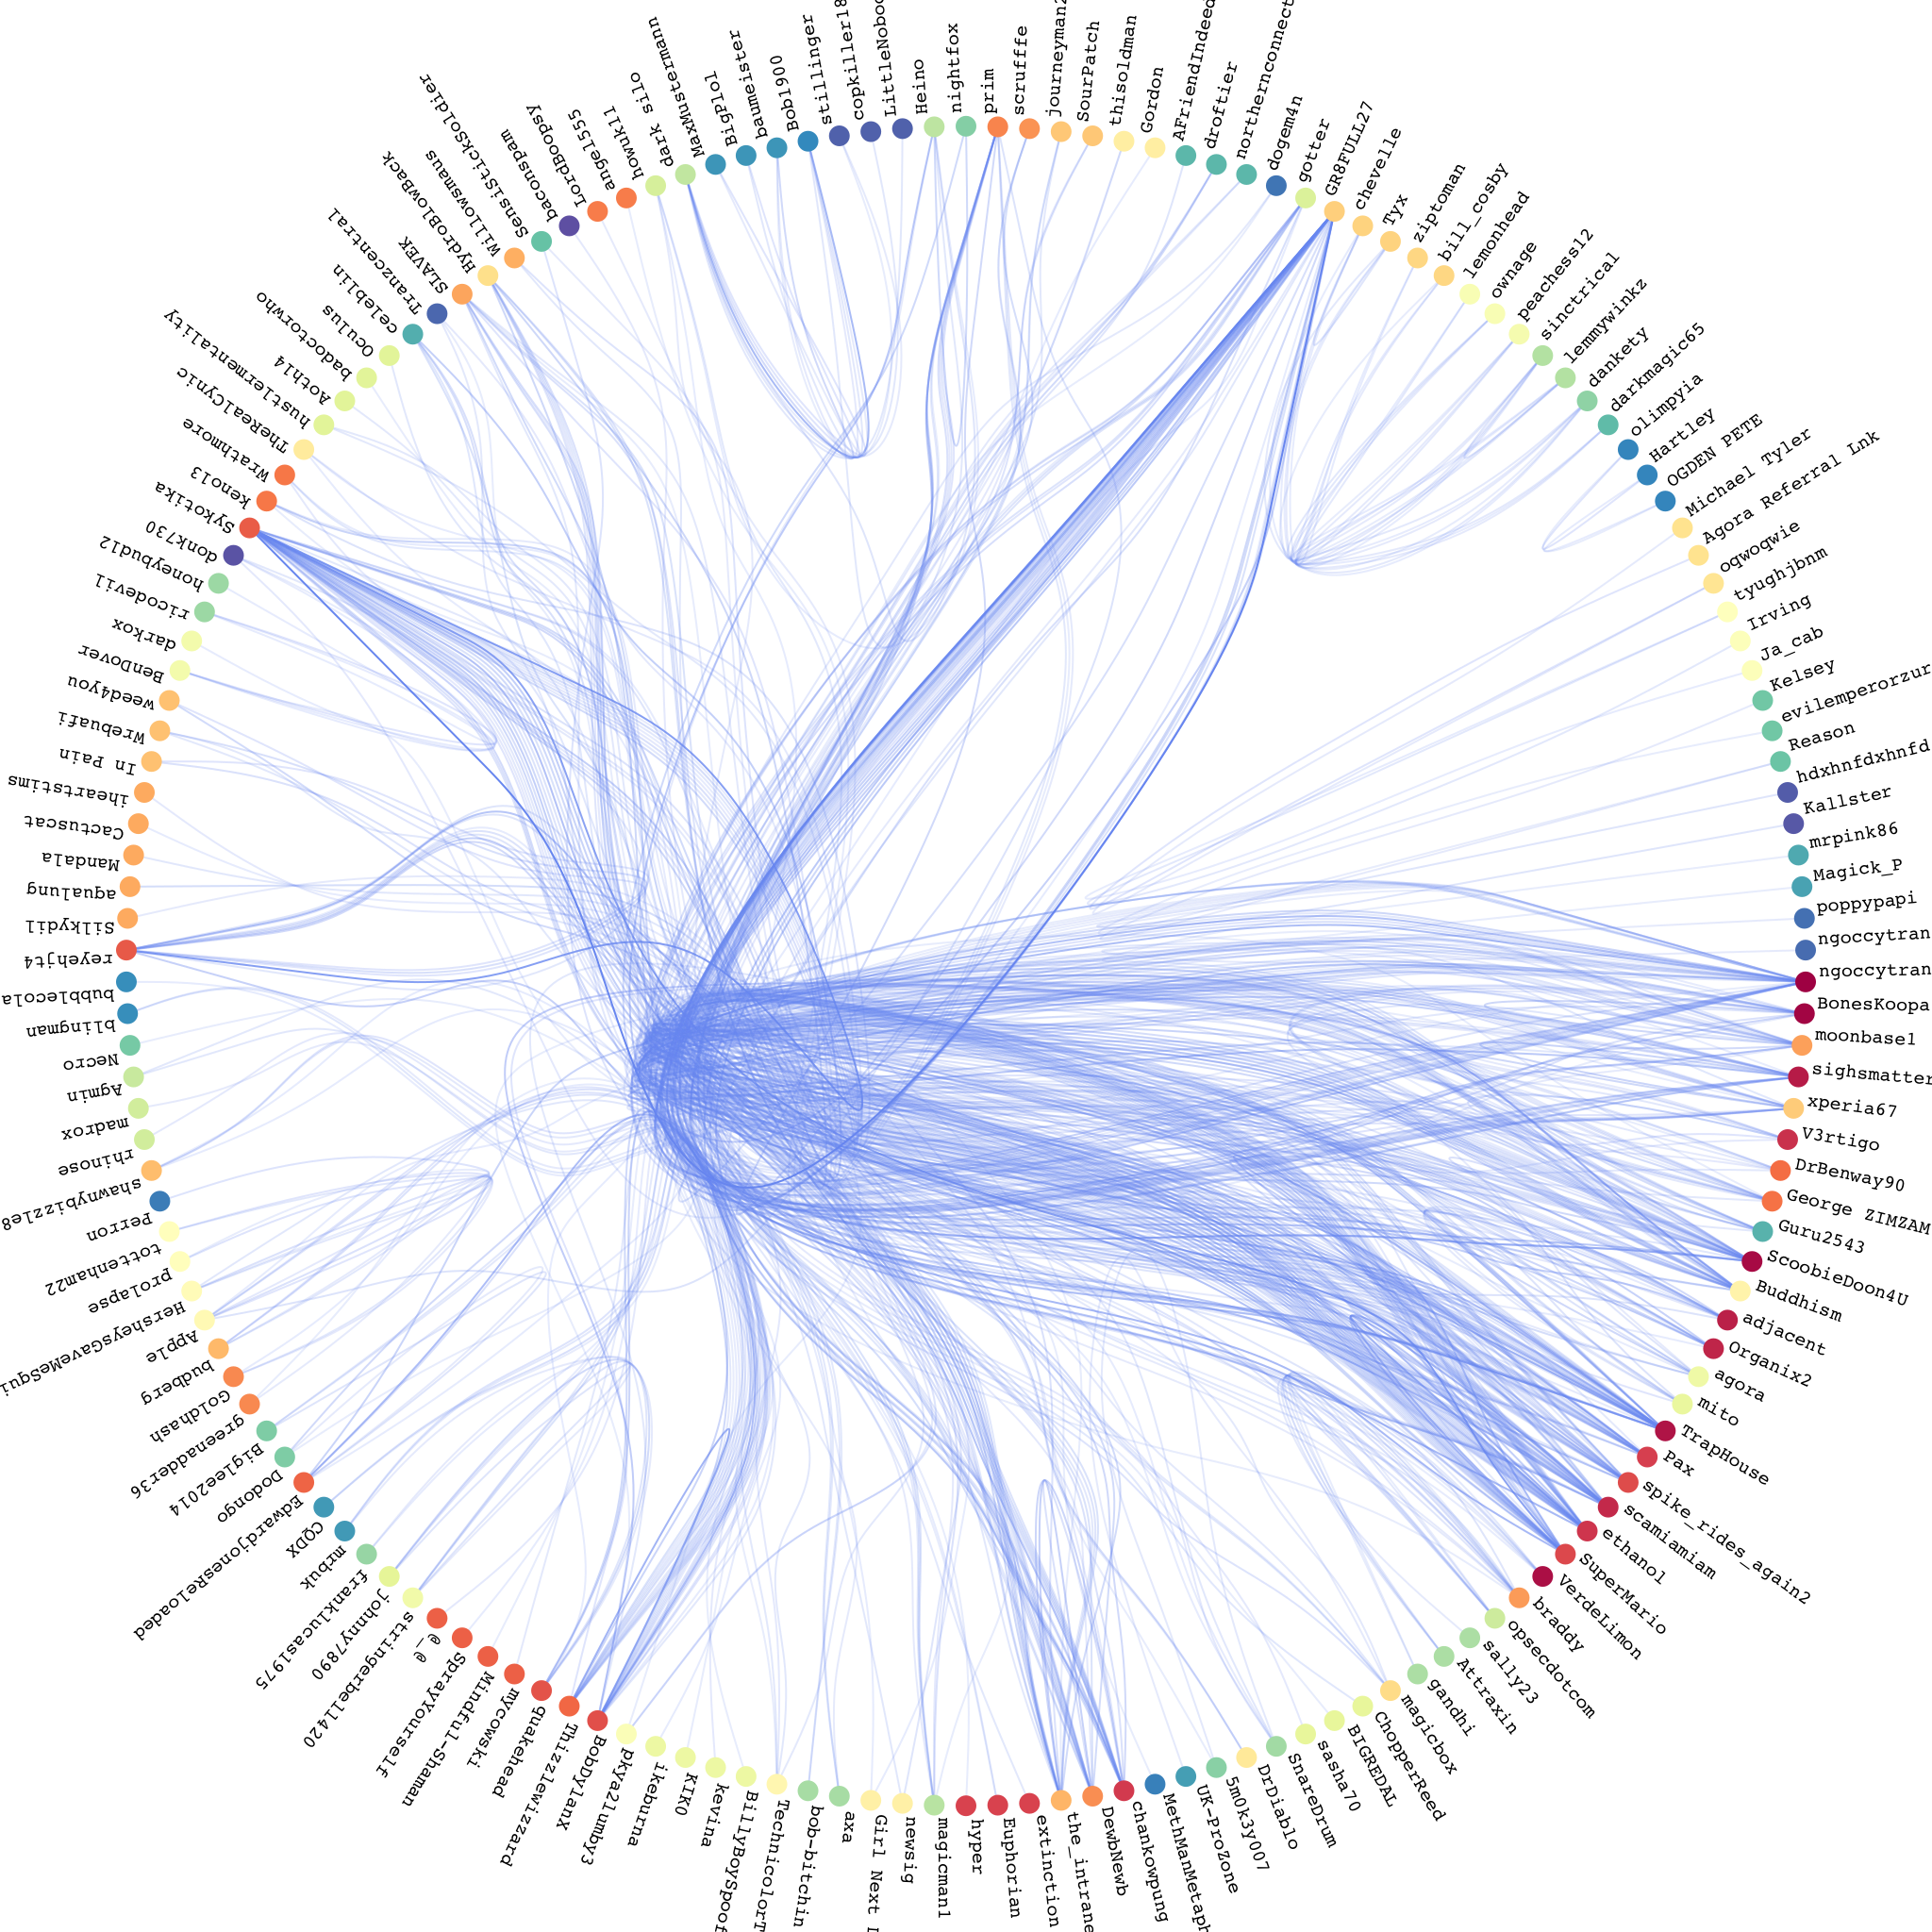

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13edd5a10, at 0x13f4df150>

In [24]:
graph_size = 1024

state = gt.community.minimize_nested_blockmodel_dl(g, deg_corr=False, eweight=g.ep['weight'])
bstack = state.get_bstack()
t = gt.community.get_hierarchy_tree(state)[0]
tpos = pos = gt.draw.radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
cts = gt.draw.get_hierarchy_control_points(g, t, tpos, beta=1.37)
pos = g.own_property(tpos)
b = bstack[0].vp["b"]

#text rotation
text_rot = g.new_vertex_property('double')
g.vertex_properties['text_rot'] = text_rot
for v in g.vertices():
    if pos[v][0] >0:
        text_rot[v] = math.atan(pos[v][1]/pos[v][0])
    else:
        text_rot[v] = math.pi + math.atan(pos[v][1]/pos[v][0])

print('saving to disk...')
gt.draw.graph_draw(g, pos=pos, vertex_fill_color=b,
            edge_control_points=cts,
            vertex_size=20,
            vertex_text=g.vertex_properties['label'],
            vertex_text_rotation=g.vertex_properties['text_rot'],
            vertex_text_position=1,
            vertex_font_size=20,
            vertex_font_family='mono',
            vertex_anchor=0,
            vertex_color=b,
            vcmap=matplotlib.cm.Spectral,
            ecmap=matplotlib.cm.Spectral,
            edge_color=g.edge_properties['color'],
            #bg_color=[0,0,0,1],
            output_size=[graph_size*2,graph_size*2],
            output='./data/agora_%d.png' % MIN_EDGE)

In [131]:
edges.keys()[0]

(5, 31)